# Required package

In [1]:
import string
import re
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
from collections import defaultdict, Counter
import numpy as np
import pickle
import pandas as pd
# from sklearn.feature_extraction.text import TfidfVectorizer
# from sklearn.preprocessing import StandardScaler, LabelEncoder
# from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader, random_split
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm


In [2]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [3]:
from google.colab import drive
drive.mount('/content/drive')

folder_path = '/content/drive/My Drive/data/preprocessed-data'

Mounted at /content/drive


# Load data

In [4]:
df_lyrics = pd.read_csv(f"{folder_path}/song_tokenized_lyrics.csv")
df_metadata = pd.read_csv(f"{folder_path}/song_metadata.csv")
df_genre = df_metadata.drop(columns=['artist', 'name', 'popularity', 'release_date','explicit', 'duration_ms', 'featured_artists'])
# df_genre.head()
# df_metadata.head()

df_music = pd.merge(df_genre,df_lyrics,on='spotify_id')
df_music = df_music.drop(columns=['spotify_id','Unnamed: 0'])

# drop song without lyrics
df_music = df_music[df_music['lyrics'] != '[]']
df_music.drop_duplicates(subset=['lyrics'], inplace=True)

In [5]:
list(df_music['genre'].value_counts())[:10]
# get top 10 genre
top_10_genres = df_music['genre'].value_counts()
# top_10_genre = top_10_genre.index[:10]
top_10_genres.iloc[0:10]

rock                 769
pop                  753
indie                532
soul                 373
alternative          297
folk                 281
hip-hop              242
acoustic             164
classic rock         159
singer-songwriter    143
Name: genre, dtype: int64

In [6]:
# get datafram only in top_10_genres
df_music_top_10 = df_music[df_music['genre'].isin(top_10_genres.index[:10])]
df_music_top_10['genre'].unique()

array(['hip-hop', 'singer-songwriter', 'classic rock', 'rock', 'pop',
       'alternative', 'soul', 'indie', 'folk', 'acoustic'], dtype=object)

In [7]:

# def tokenize(lyrics):
#     # lines = lyrics.split('\n')
#     words = word_tokenize(lyrics)
#     print(words[:100])
#     print(len(words))



# tokenize(rock[0])
# len(genre_tokenLyrics['rock'])

In [8]:
def clean_text(song):
    song = re.sub('\'m', ' am', song)
    song = re.sub('\'ve', ' have', song)
    song = re.sub('\'d ', ' would', song)
    song =re.sub('\'ll', ' will', song)
    song = re.sub('\'s', ' is', song)
    song = re.sub('\'re', ' are', song)

    song = song.lower()

    return song

genre_lyrics = defaultdict(list)

for genre, lyrics in zip(df_music_top_10['genre'], df_music_top_10['lyrics']):
    genre_lyrics[genre].append(lyrics)

rock = genre_lyrics['rock']

genre_tokenLyrics = defaultdict(list)
for genre, lyrics in genre_lyrics.items():
    tokenized_lyric = []
    for song in lyrics:
        song = clean_text(song)
        lines = song.split('\n')
        for line in lines:
            words = word_tokenize(line)
            tokenized_lyric.append(words)
    # if genre == 'rock':
    #     print(tokenized_lyric[:100])
    #     print(len(tokenized_lyric))
    genre_tokenLyrics[genre] = tokenized_lyric


# Create DataFrame

In [9]:
def pad_sentence(sentence):
    padding_sentence = np.full(50, 'pad', dtype='U50')
    length = len(sentence)
    if length < 50:
        padding_sentence[(50-length):] = sentence
    else:
        padding_sentence = sentence[(length-50):]
    return padding_sentence

# x = ['iaaa','iaaa','iaaa','iiaaa','iiaaa','iiaaa','iiaaa','iiaaa','iiaaa','iiaaa','iiaaa','iiaaa']
# y = pad_sentence(x)
# print(y)

In [10]:
genres = []
input_lyrics = []
output_words = []

for genre, lyrics in genre_tokenLyrics.items():
    for sentence in lyrics:
        if len(sentence) > 1:
            sentence = pad_sentence(sentence)
            input_sentence = sentence[:-1]
            output_word = sentence[-1]

            genres.append(genre)
            input_lyrics.append(input_sentence)
            output_words.append(output_word)


df_music_cleaned = pd.DataFrame({
    'genre': genres,
    'input_lyrics': input_lyrics,
    'output_word': output_words
})

In [11]:
# output_words[0] in string.punctuation
output_words
len(output_words)

181987

In [12]:
x = 0
for word in output_words:
    if word in string.punctuation:
        x += 1
print(x)

45368


In [13]:
df_music_cleaned

,genre,input_lyrics,output_word
0,hip-hop,"[pad, pad, pad, pad, pad, pad, pad, pad, pad, ...",]
1,hip-hop,"[pad, pad, pad, pad, pad, pad, pad, pad, pad, ...",?
2,hip-hop,"[pad, pad, pad, pad, pad, pad, pad, pad, pad, ...",?
3,hip-hop,"[pad, pad, pad, pad, pad, pad, pad, pad, pad, ...",up
4,hip-hop,"[pad, pad, pad, pad, pad, pad, pad, pad, pad, ...",paper
...,...,...,...
181982,acoustic,"[pad, pad, pad, pad, pad, pad, pad, pad, pad, ...",misunderstood
181983,acoustic,"[pad, pad, pad, pad, pad, pad, pad, pad, pad, ...",]
181984,acoustic,"[pad, pad, pad, pad, pad, pad, pad, pad, pad, ...",world
181985,acoustic,"[pad, pad, pad, pad, pad, pad, pad, pad, pad, ...",night


# DataSet

In [14]:
word_counts = Counter()
for _, tokenLyric in genre_tokenLyrics.items():
    for song in tokenLyric:
        word_counts.update(song)
    words = list(word_counts.keys())
    word_to_index = {w: idx for idx, w in enumerate(words)}
    index_to_word = {idx: w for idx, w in enumerate(words)}

# some words can't be found in Dictionary
word_to_index["<UNK>"] = len(word_to_index)

# word_to_index
genres = genre_tokenLyrics.keys()
genre_to_index = {genre: idx for idx, genre in enumerate(genres)}
index_to_genre = {idx: genre for idx, genre in enumerate(genres)}

# genre_to_index

In [15]:
class LyricsDataset(Dataset):
    def __init__(self, dataframe, word_to_index, genre_to_index):
        self.dataframe = dataframe
        self.word_to_index = word_to_index
        self.genre_to_index = genre_to_index

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        genre = self.genre_to_index[row['genre']]
        input_lyrics = [self.word_to_index.get(word, self.word_to_index["<UNK>"]) for word in row['input_lyrics']]
        output_word = self.word_to_index.get(row['output_word'], self.word_to_index["<UNK>"])
        return torch.tensor(input_lyrics, dtype=torch.long), torch.tensor(genre, dtype=torch.long), torch.tensor(output_word, dtype=torch.long)

train_dataset = LyricsDataset(df_music_cleaned, word_to_index, genre_to_index)
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)

# Train model

In [16]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [17]:
class LyricsLSTM(nn.Module):
    def __init__(self, vocab_size, genre_size, embedding_dim, hidden_dim, output_dim):
        super(LyricsLSTM, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.genre_embedding = nn.Embedding(genre_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, lyrics, genre):
        lyrics_embedded = self.embedding(lyrics)
        genre_embedded = self.genre_embedding(genre)
        combined = lyrics_embedded + genre_embedded.unsqueeze(1)
        lstm_out, _ = self.lstm(combined)
        out = self.fc(lstm_out[:, -1, :])
        return out

vocab_size = len(word_to_index)
genre_size = 10
embedding_dim = 128
hidden_dim = 128
output_dim = vocab_size
model = LyricsLSTM(vocab_size, genre_size, embedding_dim, hidden_dim, output_dim).to(device)
print(model)

LyricsLSTM(
  (embedding): Embedding(25124, 128)
  (genre_embedding): Embedding(10, 128)
  (lstm): LSTM(128, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=25124, bias=True)
)


100%|██████████| 2844/2844 [00:38<00:00, 73.44it/s]


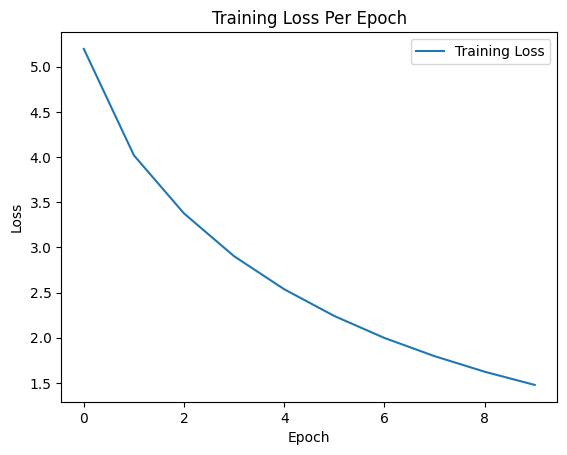

In [18]:
def train_model(model, train_loader, criterion, optimizer, num_epochs):
    total_loss_per_epoch = []

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        for lyrics, genre, target in tqdm(train_loader):
            lyrics = lyrics.to(device)
            genre = genre.to(device)
            target = target.to(device)

            optimizer.zero_grad()
            outputs = model(lyrics, genre)
            loss = criterion(outputs, target)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        avg_loss = total_loss / len(train_loader)
        total_loss_per_epoch.append(avg_loss)


    plt.plot(total_loss_per_epoch, label='Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss Per Epoch')
    plt.legend()
    plt.show()


criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
num_epochs = 10
train_model(model, train_dataloader, criterion, optimizer, num_epochs)

## Pickle model

In [19]:
with open('lyrics_model_10.pkl', 'wb') as f:
    pickle.dump(model, f)

In [89]:
# def train_model(model, train_loader, criterion, optimizer, num_epochs):
#     for epoch in range(num_epochs):
#         model.train()
#         total_loss = 0
#         for lyrics, genre, target in tqdm(train_loader):
#             lyrics = lyrics.to(device)
#             genre = genre.to(device)
#             target = target.to(device)

#             optimizer.zero_grad()
#             outputs = model(lyrics, genre)
#             loss = criterion(outputs, target)
#             loss.backward()
#             optimizer.step()
#             total_loss += loss.item()
#         print(f'Epoch {epoch+1}/{num_epochs}, Loss: {total_loss / len(train_loader)}')

# criterion = nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
# num_epochs = 3
# train_model(model, train_dataloader, criterion, optimizer, num_epochs)


## epoch 20

In [ ]:
def train_model(model, train_loader, criterion, optimizer, num_epochs):
    total_loss_per_epoch = []

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        for lyrics, genre, target in tqdm(train_loader):
            lyrics = lyrics.to(device)
            genre = genre.to(device)
            target = target.to(device)

            optimizer.zero_grad()
            outputs = model(lyrics, genre)
            loss = criterion(outputs, target)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        avg_loss = total_loss / len(train_loader)
        total_loss_per_epoch.append(avg_loss)


    plt.plot(total_loss_per_epoch, label='Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss Per Epoch')
    plt.legend()
    plt.show()


criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
num_epochs = 20
train_model(model, train_dataloader, criterion, optimizer, num_epochs)
with open('lyrics_model20epoch.pkl', 'wb') as f:
    pickle.dump(model, f)

## epoch 30

In [ ]:
def train_model(model, train_loader, criterion, optimizer, num_epochs):
    total_loss_per_epoch = []

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        for lyrics, genre, target in tqdm(train_loader):
            lyrics = lyrics.to(device)
            genre = genre.to(device)
            target = target.to(device)

            optimizer.zero_grad()
            outputs = model(lyrics, genre)
            loss = criterion(outputs, target)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        avg_loss = total_loss / len(train_loader)
        total_loss_per_epoch.append(avg_loss)


    plt.plot(total_loss_per_epoch, label='Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss Per Epoch')
    plt.legend()
    plt.show()


criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
num_epochs = 30
train_model(model, train_dataloader, criterion, optimizer, num_epochs)
with open('lyrics_model30epoch.pkl', 'wb') as f:
    pickle.dump(model, f)

# Generator Lyrics

In [ ]:
def generate_lyrics(model, seed_text, genre, word_to_index, index_to_word, genre_to_index, max_length=50):
    model.eval()

    current_text = [word_to_index.get(word, word_to_index["<UNK>"]) for word in seed_text.split()]
    genre_index = genre_to_index[genre]

    for _ in range(max_length):
        input_seq = torch.tensor([current_text], dtype=torch.long)
        genre_seq = torch.tensor([genre_index], dtype=torch.long)

        with torch.no_grad():
            output = model(input_seq, genre_seq)
            next_word_idx = torch.argmax(output, dim=1)[-1].item()

        current_text.append(next_word_idx)
        if next_word_idx == word_to_index["</s>"]:  # 假设 "</s>" 是结束符
            break

    # 将索引转换回单词
    generated_words = [index_to_word[idx] for idx in current_text]

    return ' '.join(generated_words)

# 使用示例
seed_text = "Sun shines today"
genre = "rock"
generated_lyrics = generate_lyrics(model, seed_text, genre, word_to_index, index_to_word, genre_to_index)
print(generated_lyrics)
